In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import ray
from ray.rllib.agents import ddpg
from ray.tune import register_env

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.deterministic_solution import compute_deterministic_solution

ray.init()

%matplotlib inline

In [3]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

### Config and data loading

In [4]:
config = {'path_to_data': './data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          # new and improved cool config options
          'environment_type': 'normal', # normal / gym
          'epochs': 15,
          }

In [5]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'normal', 'epochs': 15}


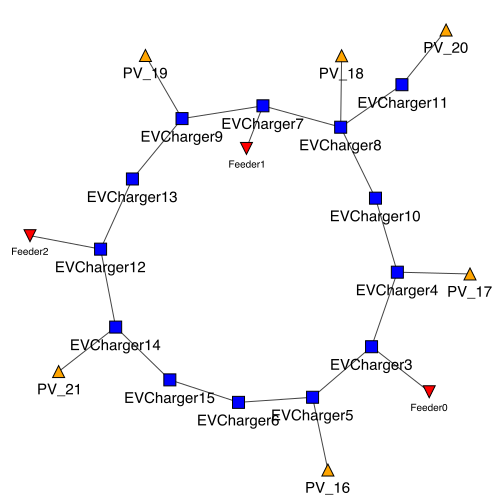

In [6]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
env.plot_grid(bbox=(0, 0, 500, 500))

### Sample runs using heuristics

Reward = 315.93


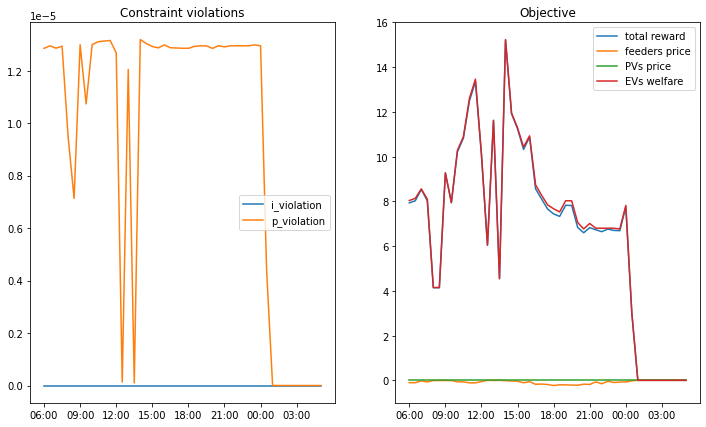

In [7]:
# Greedy heuristic which solves single-timestep OPF
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=False, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

Reward = 316.28


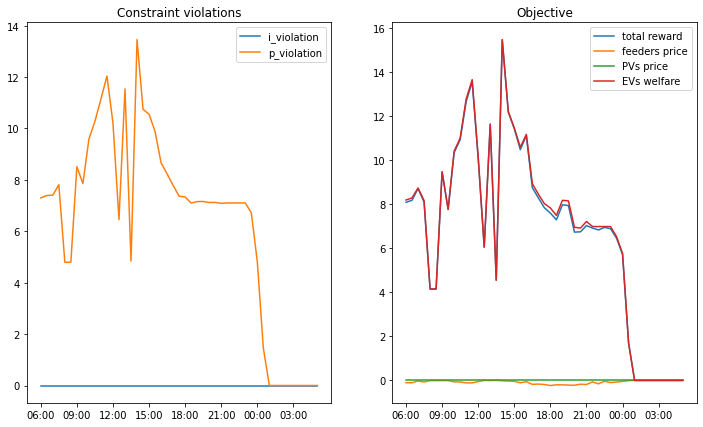

In [8]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Same simulation but using a deterministic planner

Reward = 355.67


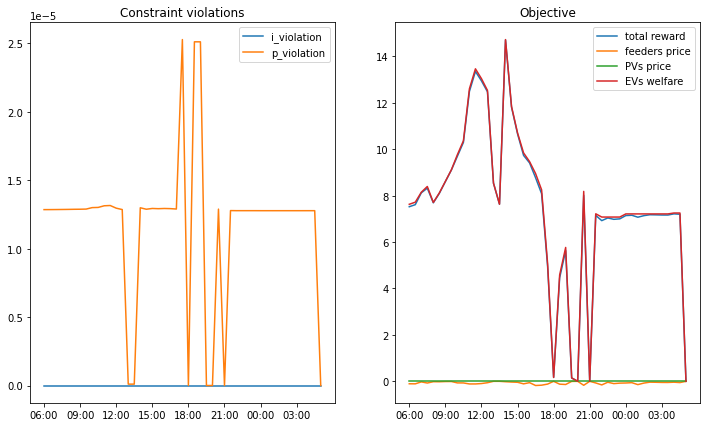

In [9]:
# Deterministic solution solves the full planning problem using perfect knowledge of the future.
# As expected, it receives higher reward.
np.random.seed(42)
env.reset(episode_index=0, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state(uncertainty='deterministic')
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
results_list = []
total_reward = 0
while not env.done:
    result = env.step(p_det[env.t_ind], v_det[env.t_ind])
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### New cool implementation using DDPG

In [10]:
# set environment type to gym for the next sections
config['environment_type'] = 'gym'

def env_creator(a):
    (ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
     price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

    return create_env(
        config,
        ps_samplers_dict,
        ps_metadata,
        canopy_sampler,
        canopy_metadata,
        price_sampler,
        price_metadata,
        ev_sampler,
        elaadnl_metadata
    )
register_env("my_env", env_creator)

### No modifications for constraints

In [11]:
trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

2022-05-25 10:50:34,828	INFO simple_q.py:161 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-05-25 10:50:34,832	INFO trainer.py:864 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=5746) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'epochs': 15}


(RolloutWorker pid=5746) 2022-05-25 10:52:39,800	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=5746) 2022-05-25 10:52:39,801	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=5746) 2022-05-25 10:52:39,910	ERROR worker.py:449 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=5746, ip=127.0.0.1, repr=<ray.rl

RayActorError: The actor died because of an error raised in its creation task, [36mray::RolloutWorker.__init__()[39m (pid=5746, ip=127.0.0.1, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x1b7a020d0>)
  File "/Users/fransdeboer/.pyenv/versions/3.9.6/lib/python3.9/site-packages/ray/rllib/evaluation/rollout_worker.py", line 507, in __init__
    check_env(self.env)
  File "/Users/fransdeboer/.pyenv/versions/3.9.6/lib/python3.9/site-packages/ray/rllib/utils/pre_checks/env.py", line 65, in check_env
    check_gym_environments(env)
  File "/Users/fransdeboer/.pyenv/versions/3.9.6/lib/python3.9/site-packages/ray/rllib/utils/pre_checks/env.py", line 160, in check_gym_environments
    next_obs, reward, done, info = env.step(sampled_action)
  File "/Users/fransdeboer/Projects/RL-EVCP/src/environments/gym_power_voltage_env.py", line 278, in step
    r = d.update_power_and_voltage(p[d_ind], v[d_ind])
  File "/Users/fransdeboer/Projects/RL-EVCP/src/devices/feeder.py", line 42, in update_power_and_voltage
    assert self.p_min - 1e-5 <= p <= self.p_max + 1e-5, \
AssertionError: Device Feeder1 received p which is out of bounds: 3.90

### Large negative reward for wrong device assignment

(RolloutWorker pid=19451) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'ignore', 'epochs': 15}


(RolloutWorker pid=19451) 2022-05-17 09:20:33,715	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=19451) 2022-05-17 09:20:33,715	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-17 09:20:33,900	INFO trainable.py:152 -- Trainable.setup took 119.198 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-17 09:20:33,902	WARNING util.

Reward = 259.42


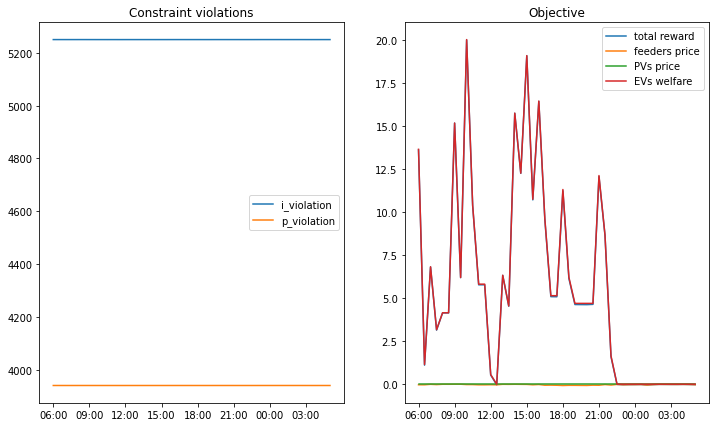

In [ ]:
config['device_constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

config['device_constraint_violation_mode'] = 'ignore'
config['constraint_violation_mode'] = 'ignore'

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Large negative reward for constraint violation, no negative reward for wrong device assignment

(RolloutWorker pid=19619) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'ignore', 'epochs': 15}


(RolloutWorker pid=19619) 2022-05-17 09:33:16,296	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=19619) 2022-05-17 09:33:16,296	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-17 09:33:16,471	INFO trainable.py:152 -- Trainable.setup took 112.140 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-17 09:33:16,473	WARNING util.

Reward = 235.83


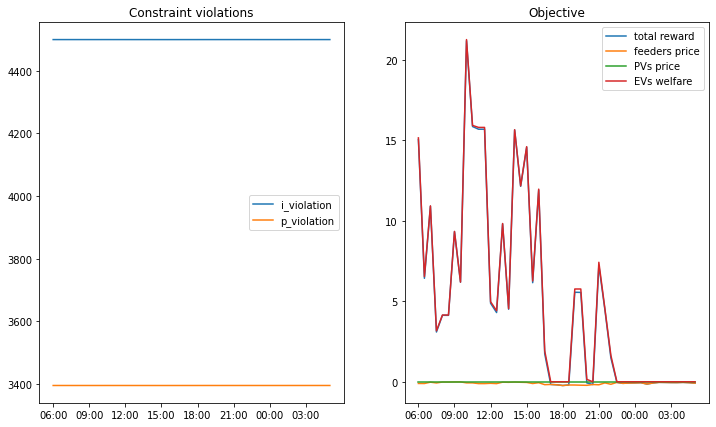

In [ ]:
config['device_constraint_violation_mode'] = 'ignore'
config['constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

config['device_constraint_violation_mode'] = 'ignore'
config['constraint_violation_mode'] = 'ignore'

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### trying both just to see what happens :D

(RolloutWorker pid=20099) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'ignore', 'epochs': 15}


(RolloutWorker pid=20099) 2022-05-17 10:09:23,075	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=20099) 2022-05-17 10:09:23,075	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-17 10:09:23,248	INFO trainable.py:152 -- Trainable.setup took 112.043 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-17 10:09:23,250	WARNING util.

Reward = 159.65


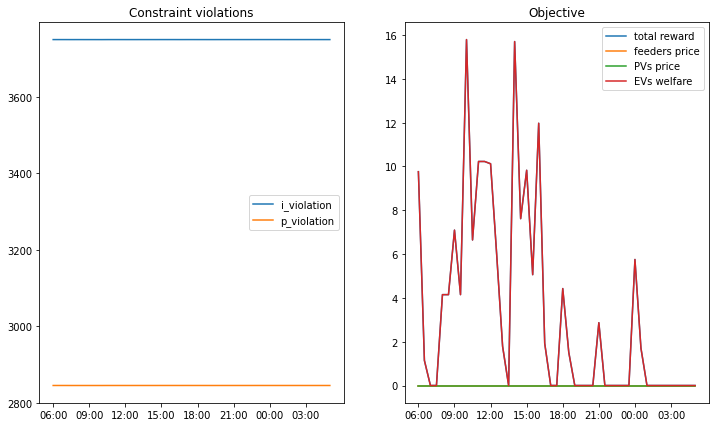

In [ ]:
config['device_constraint_violation_mode'] = 'reward'
config['constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

config['device_constraint_violation_mode'] = 'ignore'
config['constraint_violation_mode'] = 'ignore'

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the determenistic planner as it is the absolute optimal solution (assuming known future).